In [2]:
# -*- coding: utf-8 -*-
"""
Pre-process-3: Combined and Refined Multimodal Deception Detection Script
"""

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import LeaveOneGroupOut
from transformers import BertTokenizer, BertModel
from sklearn.metrics import accuracy_score, f1_score
import os
import re
import cv2 # OpenCV for video processing
import face_recognition # Mandatory for subject identification
import librosa # For audio analysis
from moviepy.editor import VideoFileClip # For extracting audio
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import time
import warnings
import torch.nn.functional as F # Needed for interpolate if using HSTA, but not used in this simpler model

# Suppress warnings from libraries like moviepy/librosa if needed
warnings.filterwarnings("ignore")

# --- Configuration ---
BERT_MODEL_NAME = 'bert-base-uncased'
VISUAL_MODEL_NAME = 'resnet18' # Using ResNet18 for visual features
AUDIO_N_MFCC = 13 # Number of MFCCs for audio features
VISUAL_FRAMES_TO_SAMPLE = 70 # Increased frames back to version 1's value [cite: 491]
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


# --- 1. Subject Identification (Mandatory Facial Recognition) ---
# Using the robust function from pre-process-2 [cite: 3, 495]
def identify_subjects_facial_recognition(data):
    """
    Identifies subjects MANDATORILY using facial recognition from the first frame.
    Maps trial_id to a subject label.

    Args:
        data (list): List of dictionaries from load_data, containing
                     'video_path' and 'video_id' (trial_id). [cite: 4]

    Returns:
        dict: A dictionary mapping trial_ids (video_ids) to subject labels
              (e.g., 'subject_1', 'unknown_trial_xyz'). [cite: 5, 494]
    """
    print("Starting mandatory facial recognition for subject identification...")
    subject_mapping = {}
    known_faces = {} # Store known face encodings and labels {label: encoding}
    subject_counter = 1
    unknown_counter = 1

    for item in data:
        video_path = item['video_path']
        trial_id = item['video_id'] # Use the actual trial_id
        subject_label = None

        try:
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                print(f"Warning: Could not open video file {video_path} for trial {trial_id}. Assigning unknown subject.")
                subject_label = f'unknown_video_open_error_{unknown_counter}'
                unknown_counter += 1
                subject_mapping[trial_id] = subject_label
                continue

            # Read the first frame
            ret, frame = cap.read()
            if not ret:
                print(f"Warning: Could not read frame from video {video_path} for trial {trial_id}. Assigning unknown subject.")
                subject_label = f'unknown_frame_read_error_{unknown_counter}'
                unknown_counter += 1
                subject_mapping[trial_id] = subject_label
                cap.release()
                continue

            # Convert the frame to RGB (face_recognition uses RGB)
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Find face locations and encodings in the frame [cite: 7, 496]
            face_locations = face_recognition.face_locations(rgb_frame)
            face_encodings = face_recognition.face_encodings(rgb_frame, face_locations)

            if not face_encodings:
                #print(f"Warning: No faces found in the first frame of video {trial_id}. Assigning unique unknown subject.")
                subject_label = f'unknown_no_face_{unknown_counter}' # Assign a unique unknown label
                unknown_counter += 1
            else:
                # Use the first face found
                current_face_encoding = face_encodings[0]

                # Check for matches with known faces
                match_found = False
                known_labels = list(known_faces.keys())
                if known_labels:
                    known_encodings = list(known_faces.values())
                    # Increase tolerance slightly if needed, default is 0.6
                    matches = face_recognition.compare_faces(known_encodings, current_face_encoding, tolerance=0.6)

                    # Find the first match
                    try:
                        first_match_index = matches.index(True)
                        subject_label = known_labels[first_match_index]
                        match_found = True
                    except ValueError: # No True value found in matches
                        pass

                if not match_found:
                    # If no match, add the face to known faces
                    subject_label = f'subject_{subject_counter}'
                    known_faces[subject_label] = current_face_encoding
                    subject_counter += 1

            subject_mapping[trial_id] = subject_label
            cap.release()

        except Exception as e:
            print(f"Error processing video {video_path} for trial {trial_id}: {e}. Assigning unknown subject.")
            subject_label = f'unknown_processing_error_{unknown_counter}'
            unknown_counter += 1
            subject_mapping[trial_id] = subject_label
            if 'cap' in locals() and cap.isOpened():
                cap.release()

    print(f"Facial recognition complete. Identified {subject_counter - 1} unique subjects and {unknown_counter - 1} videos needing unique IDs.")
    return subject_mapping


# --- 2. Data Loading ---
# Using the refined function from pre-process-2 [cite: 9, 499] that reads .txt transcriptions
def load_data(data_dir, annotation_file):
    """Loads and synchronizes annotation, transcription, and video data."""
    print("Loading data...")

    # Construct paths
    clip_dirs = [
        os.path.join(data_dir, 'Clips', 'Deceptive'),
        os.path.join(data_dir, 'Clips', 'Truthful')
    ]
    transcript_dirs = [
        os.path.join(data_dir, 'Transcription', 'Deceptive'),
        os.path.join(data_dir, 'Transcription', 'Truthful')
    ]

    # Initialize lists to store paths
    video_paths = []
    transcription_paths = []

    # Load video paths
    for clip_dir in clip_dirs:
        if os.path.isdir(clip_dir):
            for filename in os.listdir(clip_dir):
                if filename.endswith(".mp4"):
                    video_paths.append(os.path.join(clip_dir, filename))
        else:
            print(f"Warning: Clip directory not found: {clip_dir}")

    # Load transcription paths (looking for .txt files) [cite: 10, 499]
    for transcript_dir in transcript_dirs:
        if os.path.isdir(transcript_dir):
            for filename in os.listdir(transcript_dir):
                if filename.endswith(".txt"): # Changed from .csv to .txt
                    transcription_paths.append(os.path.join(transcript_dir, filename))
        else:
            print(f"Warning: Transcription directory not found: {transcript_dir}")

    # Load annotations
    try:
        annotations_df = pd.read_csv(annotation_file)
    except FileNotFoundError:
        print(f"Error: Annotation file not found at {annotation_file}")
        return []

    # Create mapping dictionaries
    video_path_dict = {}
    for video_path in video_paths:
        video_filename = os.path.basename(video_path)
        # Extract trial_id like 'trial_lie_001' or 'trial_truth_001'
        match = re.search(r"trial_(truth|lie)_(\d+)\.mp4", video_filename)
        if match:
            trial_id = f"trial_{match.group(1)}_{match.group(2)}"
            video_path_dict[trial_id] = video_path

    print(f"Found {len(video_paths)} video files")
    print(f"Found {len(transcription_paths)} transcription files")

    transcription_dict = {}
    for transcript_path in transcription_paths:
        try:
            # Read the .txt file directly [cite: 11, 500]
            with open(transcript_path, 'r', encoding='utf-8') as f:
                transcription_text = f.read().strip()

            # Extract trial_id from filename
            filename = os.path.basename(transcript_path)
            trial_id = filename.replace('.txt', '') # Remove .txt extension
            # print(f"Reading transcription file: {transcript_path}") # Optional Debug
            transcription_dict[trial_id] = transcription_text
            # print(f"Added transcription for {trial_id}") # Optional Debug
        except Exception as e:
            print(f"Error reading transcription file {transcript_path}: {e}")

    # Synchronize data
    synchronized_data = []
    processed_ids = set()

    if 'id' not in annotations_df.columns or 'class' not in annotations_df.columns:
        print(f"Error: Annotation file missing 'id' or 'class' column.")
        return []

    for _, row in annotations_df.iterrows(): # Use _ to ignore index
        # Extract trial_id from annotation 'id' column, assuming format like 'trial_lie_001.mp4'
        trial_id_raw = str(row['id'])
        match = re.search(r"trial_(truth|lie)_(\d+)", trial_id_raw)
        if not match:
             print(f"Warning: Skipping annotation row with unexpected id format: {trial_id_raw}")
             continue
        trial_id = f"trial_{match.group(1)}_{match.group(2)}"

        annotation_label = row['class']

        if annotation_label not in ['truthful', 'deceptive']:
            print(f"Warning: Skipping trial {trial_id} due to unexpected class label: {annotation_label}")
            continue

        if trial_id in processed_ids:
            print(f"Warning: Duplicate trial ID {trial_id} found in annotations. Skipping.")
            continue

        transcription_text = transcription_dict.get(trial_id)
        video_path = video_path_dict.get(trial_id)

        if transcription_text is None:
            print(f"Warning: Transcription not found for trial {trial_id}. Skipping trial.")
            continue

        if video_path is None:
            print(f"Warning: Video path not found for trial {trial_id}. Skipping trial.")
            continue

        # Map labels to numerical values
        label_map = {'truthful': 0, 'deceptive': 1}
        numeric_label = label_map.get(annotation_label)

        if numeric_label is None: # Should not happen with the check above, but good practice
            print(f"Warning: Could not map label '{annotation_label}' for trial {trial_id}. Skipping trial.")
            continue

        synchronized_data.append({
            'annotation': numeric_label,
            'transcription': transcription_text,
            'video_id': trial_id,
            'video_path': video_path
        })
        processed_ids.add(trial_id)

    print(f"Data loading complete. Found {len(synchronized_data)} synchronized trials.")
    return synchronized_data


# --- 3. Feature Extraction ---

# 3.1 NLP Feature Extraction (BERT) - Unchanged from pre-process-2 [cite: 15, 503]
def extract_nlp_features(transcriptions):
    """ Extracts BERT embeddings for a list of transcriptions. """
    print("Extracting NLP features (BERT)...")
    tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)
    model = BertModel.from_pretrained(BERT_MODEL_NAME).to(DEVICE)
    model.eval()
    nlp_features = []

    with torch.no_grad():
        for i, text in enumerate(transcriptions):
            try:
                # Ensure text is a string
                text = str(text) if text is not None else ""
                if not text.strip(): # Handle empty strings
                    print(f"Warning: Empty transcription for item {i}. Using zero vector.")
                    # Get expected hidden size from model config
                    hidden_size = model.config.hidden_size
                    sentence_embedding = np.zeros((1, hidden_size))
                else:
                    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512).to(DEVICE) # Added max_length
                    outputs = model(**inputs)
                    # Mean of the last hidden state
                    sentence_embedding = outputs.last_hidden_state.mean(dim=1).cpu().numpy() # (1, hidden_size)

                nlp_features.append(sentence_embedding)
            except Exception as e:
                print(f"Error extracting NLP features for item {i}: {e}. Using zero vector.")
                hidden_size = model.config.hidden_size
                nlp_features.append(np.zeros((1, hidden_size)))

    print("NLP feature extraction complete.")

    # Ensure all features are arrays and handle potential shape issues before stacking
    processed_features = []
    target_shape = None
    if nlp_features: # Find target shape from the first valid feature
         for feat in nlp_features:
             if isinstance(feat, np.ndarray):
                 target_shape = feat.shape
                 break

    if target_shape is None and nlp_features: # If no valid features found but list not empty
        # Fallback: try to get shape from model config if possible
        try:
             target_shape = (1, model.config.hidden_size)
             print(f"Warning: Could not determine NLP target shape from features, using default BERT hidden size: {target_shape}")
        except Exception:
             print("Error: Cannot determine NLP feature shape. Returning empty array.")
             return np.array([]) # Cannot proceed without a shape
    elif not nlp_features:
        print("Warning: No NLP features extracted.")
        return np.array([])


    for feat in nlp_features:
        if isinstance(feat, np.ndarray):
            if feat.shape == target_shape:
                processed_features.append(feat)
            else:
                # If shape mismatch, pad or truncate (or use zeros as done in exception handling)
                print(f"Warning: NLP feature shape mismatch ({feat.shape} vs {target_shape}). Using zero vector of target shape.")
                processed_features.append(np.zeros(target_shape))
        else: # Should not happen if exceptions are caught, but as safeguard
            print(f"Warning: Non-array NLP feature found. Using zero vector of target shape.")
            processed_features.append(np.zeros(target_shape))


    if not processed_features:
        return np.array([]) # Return empty array if no features were processed

    return np.vstack(processed_features) # (num_trials, hidden_size)


# 3.2 Audio Feature Extraction (MFCCs) - Unchanged from pre-process-2 [cite: 18, 506]
def extract_audio_features(video_paths):
    """ Extracts MFCC features from the audio track of video files. """
    print("Extracting Audio features (MFCCs)...")
    audio_features = []
    temp_audio_dir = "temp_audio"
    if not os.path.exists(temp_audio_dir):
        os.makedirs(temp_audio_dir)

    num_features = AUDIO_N_MFCC * 2 # Mean and Std Dev for each MFCC

    for i, video_path in enumerate(video_paths):
        # start_time = time.time() # Optional timer
        temp_audio_path = os.path.join(temp_audio_dir, f"temp_{os.path.basename(video_path)}.wav") # More robust temp name
        feature_vector = np.zeros(num_features) # Default to zeros

        try:
            # Extract audio using moviepy
            with VideoFileClip(video_path) as video_clip:
                if video_clip.audio is None:
                    print(f"Warning: Video {i} ({os.path.basename(video_path)}) has no audio track. Using zeros.")
                else:
                    # Specify logger=None to reduce console output
                    video_clip.audio.write_audiofile(temp_audio_path, codec='pcm_s16le', logger=None)

                    # Load audio and extract MFCCs using librosa
                    # Load with native sample rate, librosa handles resampling if needed by feature extraction
                    y, sr = librosa.load(temp_audio_path, sr=None)

                    if len(y) > 0: # Check if audio signal is not empty
                        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=AUDIO_N_MFCC)
                        mfccs_mean = np.mean(mfccs, axis=1)
                        mfccs_std = np.std(mfccs, axis=1)
                        feature_vector = np.concatenate((mfccs_mean, mfccs_std))
                    else:
                        print(f"Warning: Audio signal empty after extraction for video {i}. Using zeros.")

        except Exception as e:
            print(f"Error extracting audio features for video {i} ({os.path.basename(video_path)}): {e}. Using zeros.")
            # Ensure feature_vector remains zeros

        finally:
            # Clean up temporary audio file
            if os.path.exists(temp_audio_path):
                try:
                    os.remove(temp_audio_path)
                except Exception as e_rem: # Different variable name for exception
                    print(f"Warning: Could not remove temp audio file {temp_audio_path}: {e_rem}")

        audio_features.append(feature_vector)
        # Optional progress print:
        # print(f"Processed audio for video {i+1}/{len(video_paths)} in {time.time() - start_time:.2f}s")

    # Clean up temp directory if empty
    try:
        if os.path.exists(temp_audio_dir) and not os.listdir(temp_audio_dir):
             os.rmdir(temp_audio_dir)
    except Exception as e_rem_dir:
        print(f"Warning: Could not remove temp audio directory {temp_audio_dir}: {e_rem_dir}")

    print("Audio feature extraction complete.")
    return np.array(audio_features) # (num_trials, num_audio_features)


# 3.3 Visual Feature Extraction (ResNet) - Using sampling rate from version 1 [cite: 491]
def extract_visual_features(video_paths):
    """ Extracts aggregated visual features using a pre-trained ResNet model. """
    print("Extracting Visual features (ResNet)...")

    # Load pre-trained ResNet model without the final classification layer
    vis_model = models.resnet18(pretrained=True)
    vis_model = nn.Sequential(*list(vis_model.children())[:-1]) # Remove the fully connected layer
    vis_model = vis_model.to(DEVICE)
    vis_model.eval()

    # Define image transformations appropriate for ResNet
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    visual_features = []
    num_visual_features = 512 # ResNet18 output size before FC layer

    with torch.no_grad():
        for i, video_path in enumerate(video_paths):
            # start_time = time.time() # Optional timer
            video_feature_vector = np.zeros(num_visual_features) # Default to zeros

            try:
                cap = cv2.VideoCapture(video_path)
                if not cap.isOpened():
                    print(f"Warning: Could not open video {i} ({os.path.basename(video_path)}). Using zeros.")
                    visual_features.append(video_feature_vector)
                    continue

                frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                if frame_count <= 0:
                    print(f"Warning: Video {i} ({os.path.basename(video_path)}) has no frames or invalid frame count. Using zeros.")
                    visual_features.append(video_feature_vector)
                    cap.release()
                    continue

                # Sample frames evenly across the video - using VISUAL_FRAMES_TO_SAMPLE = 70 [cite: 491]
                num_frames_to_sample = min(VISUAL_FRAMES_TO_SAMPLE, frame_count) # Don't sample more than available
                if num_frames_to_sample > 0:
                    frame_indices = np.linspace(0, frame_count - 1, num_frames_to_sample, dtype=int)
                else:
                    frame_indices = [] # Should not happen due to frame_count check, but safeguard

                frames_data = []
                for frame_index in frame_indices:
                    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
                    ret, frame = cap.read()
                    if ret:
                        # Convert frame BGR -> RGB -> PIL Image -> Apply transforms
                        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                        img_pil = Image.fromarray(frame_rgb)
                        img_tensor = preprocess(img_pil).unsqueeze(0).to(DEVICE) # Add batch dimension
                        frames_data.append(img_tensor)
                    # else: # Optional: Warn if specific frame fails
                        # print(f"Warning: Could not read frame {frame_index} from video {i}.")

                cap.release()

                if frames_data:
                    # Stack frame tensors and pass through the model
                    batch_tensor = torch.cat(frames_data, dim=0)
                    frame_outputs = vis_model(batch_tensor) # (num_sampled_frames, num_visual_features, 1, 1)
                    frame_outputs = frame_outputs.squeeze() # Remove trailing 1s -> (num_sampled_frames, num_visual_features)

                    # Handle case where only one frame was sampled (squeeze might remove batch dim)
                    if frame_outputs.ndim == 1:
                        video_feature_vector = frame_outputs.cpu().numpy()
                    elif frame_outputs.ndim == 2:
                         # Aggregate features (e.g., mean pooling)
                         video_feature_vector = torch.mean(frame_outputs, dim=0).cpu().numpy()
                    else: # Should not happen
                         print(f"Warning: Unexpected visual feature dimension {frame_outputs.ndim} for video {i}. Using zeros.")
                         video_feature_vector = np.zeros(num_visual_features) # Fallback

                else:
                    print(f"Warning: No frames could be processed for video {i} ({os.path.basename(video_path)}). Using zeros.")
                    # video_feature_vector remains zeros

            except Exception as e:
                print(f"Error extracting visual features for video {i} ({os.path.basename(video_path)}): {e}. Using zeros.")
                if 'cap' in locals() and cap.isOpened():
                    cap.release()
                # video_feature_vector remains zeros

            visual_features.append(video_feature_vector)
            # Optional progress print:
            # print(f"Processed visual for video {i+1}/{len(video_paths)} in {time.time() - start_time:.2f}s")

    print("Visual feature extraction complete.")
    return np.array(visual_features) # (num_trials, num_visual_features)


# --- 4. Data Preparation for LOSO ---
# Unchanged from pre-process-2 [cite: 27, 515]
def prepare_loso(data, subject_mapping):
    """
    Prepares data for LOSO cross-validation using the mandatory subject mapping.
    Returns filtered annotations, raw transcriptions, mapped subject IDs, and valid indices.
    """
    print("Preparing data for LOSO...")
    annotations = [item['annotation'] for item in data]
    transcriptions = [item['transcription'] for item in data] # Keep raw text
    video_ids = [item['video_id'] for item in data]

    # Map video_ids (trial_ids) to subject IDs using the facial recognition mapping
    mapped_subject_ids = []
    valid_indices = [] # Keep track of trials with successful subject mapping

    for idx, video_id in enumerate(video_ids):
        subject_id = subject_mapping.get(video_id)
        if subject_id is None:
            print(f"Critical Warning: No subject mapping found for video_id {video_id}. This trial will be skipped in prepare_loso.")
        else:
            # Ensure subject IDs are suitable for LOSO grouping (e.g., string or int)
            # The current mapping creates strings like 'subject_1' or 'unknown_no_face_1' which is fine.
            mapped_subject_ids.append(subject_id)
            valid_indices.append(idx)

    if not valid_indices:
         print("Error: No trials have valid subject mappings. Cannot proceed.")
         return np.array([]), [], [], []


    if len(valid_indices) < len(data):
        print(f"Warning: {len(data) - len(valid_indices)} trials were skipped due to missing subject mapping.")

    # Filter data based on valid indices
    annotations_filtered = np.array(annotations)[valid_indices]
    transcriptions_filtered = [transcriptions[i] for i in valid_indices]
    # The mapped_subject_ids list already corresponds to the valid_indices
    # No, we need to filter the subject_ids based on the final mapping result. Let's rebuild it.
    mapped_subject_ids_filtered = [subject_mapping.get(video_ids[i]) for i in valid_indices]


    print(f"Data preparation complete. {len(annotations_filtered)} trials ready for LOSO.")
    # Note: Audio/Visual features are extracted separately AFTER prepare_loso filters trials
    return annotations_filtered, transcriptions_filtered, mapped_subject_ids_filtered, valid_indices


# --- 5. Multimodal Model Implementation ---
# Reverted to the simpler model from pre-process (version 1) [cite: 519, 520]
class MultimodalDeceptionModel(nn.Module):
    """
    Simpler multimodal model for deception detection using NLP, Audio, and Visual features
    (Based on the architecture from the first provided script).
    """
    def __init__(self, nlp_input_size, audio_input_size, visual_input_size, hidden_size, num_classes):
        super(MultimodalDeceptionModel, self).__init__()
        # Simple linear processors for each modality
        self.nlp_processor = nn.Linear(nlp_input_size, hidden_size)
        self.audio_processor = nn.Linear(audio_input_size, hidden_size)
        self.visual_processor = nn.Linear(visual_input_size, hidden_size)

        # Activation
        self.relu = nn.ReLU()

        # Fusion and Classifier layers
        self.fusion_dropout = nn.Dropout(0.5) # Dropout after fusion
        # Input size to classifier is concatenation of processed features
        self.classifier = nn.Linear(hidden_size * 3, num_classes)


    def forward(self, nlp_data, audio_data, visual_data):
        """ Forward pass processing and fusing features. """
        # Process each modality through its linear layer and activation
        nlp_processed = self.relu(self.nlp_processor(nlp_data))
        audio_processed = self.relu(self.audio_processor(audio_data))
        visual_processed = self.relu(self.visual_processor(visual_data))

        # Fusion by concatenation
        fused_features = torch.cat((nlp_processed, audio_processed, visual_processed), dim=1)

        # Apply dropout
        fused_features = self.fusion_dropout(fused_features)

        # Final classification layer
        output = self.classifier(fused_features)
        return output


# --- 6. Training and Evaluation ---
# Unchanged from pre-process-2 [cite: 31, 521]
def train_evaluate(model,
                   nlp_train, audio_train, visual_train, labels_train,
                   nlp_test, audio_test, visual_test, labels_test,
                   optimizer, criterion, device, epoch):
    """ Trains and evaluates the multimodal model for one epoch. """
    # --- Training Phase ---
    model.train()
    optimizer.zero_grad()

    # Move training data to device
    nlp_train_tensor = torch.FloatTensor(nlp_train).to(device)
    audio_train_tensor = torch.FloatTensor(audio_train).to(device)
    visual_train_tensor = torch.FloatTensor(visual_train).to(device)
    labels_train_tensor = torch.LongTensor(labels_train).to(device)

    # Forward pass (Training)
    outputs = model(nlp_train_tensor, audio_train_tensor, visual_train_tensor)
    loss = criterion(outputs, labels_train_tensor)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    train_loss_item = loss.item() # Get loss value for reporting

    # --- Evaluation Phase ---
    model.eval()
    with torch.no_grad():
        # Move test data to device
        nlp_test_tensor = torch.FloatTensor(nlp_test).to(device)
        audio_test_tensor = torch.FloatTensor(audio_test).to(device)
        visual_test_tensor = torch.FloatTensor(visual_test).to(device)
        labels_test_tensor = torch.LongTensor(labels_test).to(device)

        # Forward pass (Evaluation)
        outputs_test = model(nlp_test_tensor, audio_test_tensor, visual_test_tensor)
        _, predicted = torch.max(outputs_test.data, 1)

        # Calculate metrics
        labels_test_cpu = labels_test_tensor.cpu().numpy()
        predicted_cpu = predicted.cpu().numpy()

        accuracy = accuracy_score(labels_test_cpu, predicted_cpu)
        f1 = f1_score(labels_test_cpu, predicted_cpu, average='weighted', zero_division=0) # Added zero_division

    return accuracy, f1, train_loss_item # Return loss from the training pass


# --- 7. Run LOSO Cross-Validation ---
# Checkpoint loading logic updated slightly to match the simpler model structure.
def run_loso(annotations, nlp_features, audio_features, visual_features, subject_ids,
             checkpoint_dir="checkpoints", num_epochs=50, learning_rate=0.001, hidden_size=128):
    """ Runs LOSO cross-validation for the multimodal model. """
    print("Starting LOSO Cross-Validation...")
    loso = LeaveOneGroupOut()
    all_accuracies = []
    all_f1s = []
    all_fold_losses = [] # Store average loss of last epoch per fold

    num_seeds = 3 # Number of random seeds for stability [cite: 34, 524]

    # Create checkpoint directory if it doesn't exist
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    num_classes = len(np.unique(annotations))
    if num_classes < 2:
        print(f"Error: Only {num_classes} unique class found. Cannot perform classification.")
        return

    # Ensure all feature arrays have the same number of samples as annotations/subject_ids
    n_samples = len(annotations)
    if not (len(nlp_features) == n_samples and len(audio_features) == n_samples and len(visual_features) == n_samples and len(subject_ids) == n_samples):
         print("Error: Feature array lengths do not match annotation/subject ID lengths after filtering!")
         print(f"Lengths: Annotations={n_samples}, NLP={len(nlp_features)}, Audio={len(audio_features)}, Visual={len(visual_features)}, Subjects={len(subject_ids)}")
         return # Cannot proceed if lengths mismatch


    fold_num = 0
    n_splits = loso.get_n_splits(groups=subject_ids)

    for train_index, test_index in loso.split(X=nlp_features, y=annotations, groups=subject_ids): # Provide X and y
        fold_num += 1
        fold_accuracies_seeds = []
        fold_f1s_seeds = []
        fold_last_epoch_losses_seeds = [] # Store loss of the last epoch for each seed

        # Identify the subject(s) being left out in this fold
        test_subjects = np.unique(np.array(subject_ids)[test_index])
        test_subject_str = ', '.join(map(str, test_subjects)) # Handle multiple subjects if group has >1 type
        print(f"\n--- Fold {fold_num}/{n_splits}: Testing on Subject(s) {test_subject_str} ---")

        # Split data for this fold
        nlp_train, nlp_test = nlp_features[train_index], nlp_features[test_index]
        audio_train, audio_test = audio_features[train_index], audio_features[test_index]
        visual_train, visual_test = visual_features[train_index], visual_features[test_index]
        labels_train, labels_test = annotations[train_index], annotations[test_index]

        # Check if train or test set is empty for this fold
        if len(labels_train) == 0 or len(labels_test) == 0:
            print(f"Warning: Skipping Fold {fold_num} due to empty train ({len(labels_train)}) or test ({len(labels_test)}) set.")
            continue

        # Get feature dimensions dynamically
        try:
            nlp_dim = nlp_train.shape[1]
            audio_dim = audio_train.shape[1]
            visual_dim = visual_train.shape[1]
        except IndexError:
             print(f"Error: Could not get feature dimensions in Fold {fold_num}. Skipping fold.")
             print(f"Shapes: NLP={nlp_train.shape}, Audio={audio_train.shape}, Visual={visual_train.shape}")
             continue


        for seed in range(num_seeds):
            print(f"  Seed {seed + 1}/{num_seeds}")
            # Set seeds for reproducibility
            torch.manual_seed(seed)
            np.random.seed(seed)
            if torch.cuda.is_available():
                 torch.cuda.manual_seed_all(seed) # for multi-GPU


            # Model initialization, optimizer, and loss function
            # Using the simpler model architecture [cite: 519, 520]
            model = MultimodalDeceptionModel(
                nlp_input_size=nlp_dim,
                audio_input_size=audio_dim,
                visual_input_size=visual_dim,
                hidden_size=hidden_size,
                num_classes=num_classes
            ).to(DEVICE)
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
            criterion = nn.CrossEntropyLoss().to(DEVICE)

            # Define checkpoint file name
            checkpoint_file = os.path.join(checkpoint_dir, f"fold_{fold_num}_seed_{seed + 1}.pth")

            # Check if checkpoint exists and load it
            start_epoch = 0
            if os.path.exists(checkpoint_file):
                try:
                    # Load checkpoint onto the correct device
                    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
                    model.load_state_dict(checkpoint['model_state_dict'])
                    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                    start_epoch = checkpoint['epoch']
                    last_loss = checkpoint.get('loss', 'N/A') # Get last saved loss if available
                    print(f"    Resuming training from checkpoint {checkpoint_file} at epoch {start_epoch + 1} (Last saved loss: {last_loss})")
                except Exception as e:
                    print(f"    Warning: Could not load checkpoint {checkpoint_file}: {e}. Starting from scratch.")
                    start_epoch = 0 # Reset start epoch if loading failed

            # Train and evaluate the model
            best_f1_seed = -1.0 # Track best F1 for saving the best model state for this seed
            last_epoch_loss_this_seed = float('nan') # Initialize loss for this seed

            for epoch in range(start_epoch, num_epochs):
                accuracy, f1, loss = train_evaluate(
                    model,
                    nlp_train, audio_train, visual_train, labels_train,
                    nlp_test, audio_test, visual_test, labels_test,
                    optimizer, criterion, DEVICE, epoch)

                last_epoch_loss_this_seed = loss # Store loss for the current epoch

                # Optional: Save checkpoint based on best F1 for this seed
                if f1 > best_f1_seed:
                    best_f1_seed = f1
                    # print(f"      Epoch {epoch + 1}/{num_epochs} - Loss: {loss:.4f}, Acc: {accuracy:.4f}, F1: {f1:.4f} (New best F1, saving checkpoint)") # Verbose saving log
                    torch.save({
                        'epoch': epoch + 1, # Save the epoch number *after* completion
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': loss,
                        'f1': f1, # Save F1 score in checkpoint
                        'accuracy': accuracy,
                        # Save model hyperparams used for this checkpoint
                        'hidden_size': hidden_size,
                        'learning_rate': learning_rate,
                        'nlp_input_size': nlp_dim,
                        'audio_input_size': audio_dim,
                        'visual_input_size': visual_dim,
                        'num_classes': num_classes
                    }, checkpoint_file)
                # else: # Optional print for epochs that don't improve F1
                    # print(f"      Epoch {epoch + 1}/{num_epochs} - Loss: {loss:.4f}, Acc: {accuracy:.4f}, F1: {f1:.4f}")

            # --- After training loop for the seed ---
            # Load the best model state saved for this seed based on F1 and evaluate
            final_seed_accuracy = float('nan')
            final_seed_f1 = float('nan')

            if os.path.exists(checkpoint_file):
                 try:
                    # print(f"    Loading best checkpoint for seed {seed + 1} to get final metrics...")
                    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
                    # Re-initialize model to ensure clean load
                    model = MultimodalDeceptionModel(
                            nlp_input_size=checkpoint['nlp_input_size'], # Use saved dims
                            audio_input_size=checkpoint['audio_input_size'],
                            visual_input_size=checkpoint['visual_input_size'],
                            hidden_size=checkpoint['hidden_size'],
                            num_classes=checkpoint['num_classes']
                            ).to(DEVICE)
                    model.load_state_dict(checkpoint['model_state_dict'])
                    model.eval() # Set model to evaluation mode
                    with torch.no_grad():
                         nlp_test_tensor = torch.FloatTensor(nlp_test).to(DEVICE)
                         audio_test_tensor = torch.FloatTensor(audio_test).to(DEVICE)
                         visual_test_tensor = torch.FloatTensor(visual_test).to(DEVICE)
                         labels_test_tensor = torch.LongTensor(labels_test).to(DEVICE)
                         outputs_final_test = model(nlp_test_tensor, audio_test_tensor, visual_test_tensor)
                         _, predicted_final = torch.max(outputs_final_test.data, 1)
                         labels_test_cpu = labels_test_tensor.cpu().numpy()
                         predicted_final_cpu = predicted_final.cpu().numpy()
                         final_seed_accuracy = accuracy_score(labels_test_cpu, predicted_final_cpu)
                         final_seed_f1 = f1_score(labels_test_cpu, predicted_final_cpu, average='weighted', zero_division=0)
                    print(f"    Seed {seed + 1} Final Results (Best F1 Model) - Accuracy: {final_seed_accuracy:.4f}, F1: {final_seed_f1:.4f}")

                 except Exception as e_load_final:
                      print(f"    Warning: Could not load or evaluate best checkpoint {checkpoint_file} for final metrics: {e_load_final}")
                      # Use metrics from the very last epoch as fallback
                      final_seed_accuracy = accuracy
                      final_seed_f1 = f1
                      print(f"    Using results from last epoch instead: Accuracy: {final_seed_accuracy:.4f}, F1: {final_seed_f1:.4f}")

            else:
                 print(f"    Warning: No checkpoint found for seed {seed + 1} after training. Cannot report final metrics.")


            # Store results (from the best model if loaded, else last epoch) for this seed
            fold_accuracies_seeds.append(final_seed_accuracy)
            fold_f1s_seeds.append(final_seed_f1)
            fold_last_epoch_losses_seeds.append(last_epoch_loss_this_seed) # Still store last epoch loss

        # --- After all seeds for the fold ---
        # Average metrics across seeds for this fold (handle potential NaNs if a seed failed)
        if fold_accuracies_seeds: # Check if any seeds ran successfully
            avg_fold_accuracy = np.nanmean(fold_accuracies_seeds) # Use nanmean
            avg_fold_f1 = np.nanmean(fold_f1s_seeds)
            avg_fold_last_epoch_loss = np.nanmean(fold_last_epoch_losses_seeds)

            all_accuracies.append(avg_fold_accuracy)
            all_f1s.append(avg_fold_f1)
            all_fold_losses.append(avg_fold_last_epoch_loss)
            print(f"  Fold {fold_num} Average (across seeds) - Accuracy: {avg_fold_accuracy:.4f}, F1: {avg_fold_f1:.4f}, Last Epoch Loss: {avg_fold_last_epoch_loss:.4f}")
        else:
            print(f"  Fold {fold_num} - No successful seed runs.")

    # --- After all folds ---
    # Overall results across folds (handle potential NaNs if a fold failed)
    if all_accuracies:
        overall_avg_accuracy = np.nanmean(all_accuracies) # Use nanmean
        overall_avg_f1 = np.nanmean(all_f1s)
        overall_avg_loss = np.nanmean(all_fold_losses)
        print(f"\n--- Overall LOSO Results (Avg. Across Folds & Seeds) ---")
        print(f"Overall Average Accuracy: {overall_avg_accuracy:.4f}")
        print(f"Overall Average F1-score: {overall_avg_f1:.4f}")
        print(f"Overall Average Last Epoch Loss: {overall_avg_loss:.4f}")
    else:
        print("\n--- No folds completed successfully. Cannot calculate overall results. ---")



# --- 8. Main Execution Block ---
if __name__ == "__main__":
    start_main_time = time.time()

    # --- Configuration ---
    # !!! ADJUST THESE PATHS TO YOUR DATASET LOCATION !!!
    # Using paths from the provided scripts [cite: 46, 534]
    data_dir = 'Real-life_Deception_Detection_2016' # Example path, adjust as needed
    annotation_file = os.path.join(data_dir, 'Annotation', 'All_Gestures_Deceptive and Truthful.csv') # Construct path robustly
    checkpoint_dir = "multimodal_checkpoints_simple" # Use a different dir for the simple model checkpoints
    num_epochs_main = 50 # Adjust number of epochs if needed [cite: 46, 534]
    learning_rate_main = 0.001 # [cite: 46, 534]
    hidden_size_main = 128 # Hidden dimension for feature processing/fusion [cite: 46, 534]

    print(f"--- Starting Deception Detection Pipeline ---")
    print(f"Dataset Directory: {os.path.abspath(data_dir)}")
    print(f"Annotation File: {os.path.abspath(annotation_file)}")
    print(f"Checkpoints Directory: {os.path.abspath(checkpoint_dir)}")
    print(f"Device: {DEVICE}")
    print(f"Number of Epochs: {num_epochs_main}")
    print(f"Learning Rate: {learning_rate_main}")
    print(f"Hidden Size: {hidden_size_main}")
    print(f"Visual Frames to Sample: {VISUAL_FRAMES_TO_SAMPLE}")
    print(f"Audio MFCCs: {AUDIO_N_MFCC}")
    print(f"-------------------------------------------")


    # --- Workflow ---
    # 1. Load Data (Paths, Annotations, Transcriptions)
    data = load_data(data_dir, annotation_file)
    if not data:
        print("No data loaded. Exiting.")
        exit()

    # 2. Identify Subjects (Mandatory Facial Recognition) [cite: 535]
    subject_mapping = identify_subjects_facial_recognition(data)
    # print("Subject Mapping (Facial Recognition):", subject_mapping) # Optional print for debugging

    # 3. Prepare Data for LOSO (Get filtered annotations, raw transcriptions, mapped IDs) [cite: 535]
    annotations, transcriptions_raw, mapped_subject_ids, valid_indices = prepare_loso(data, subject_mapping)
    if len(annotations) == 0:
        print("No valid trials remaining after preparing for LOSO. Exiting.")
        exit()

    # Filter original data list based on valid indices from prepare_loso
    # This ensures feature extraction only happens for trials included in LOSO
    valid_data = [data[i] for i in valid_indices]
    video_paths_valid = [item['video_path'] for item in valid_data]

    # Check if video_paths_valid is empty, which means no valid trials remained
    if not video_paths_valid:
         print("Error: No valid video paths found after LOSO preparation. Exiting.")
         exit()


    # 4. Extract Features for the valid trials [cite: 536]
    nlp_features = extract_nlp_features(transcriptions_raw) # Takes raw text list
    audio_features = extract_audio_features(video_paths_valid)
    visual_features = extract_visual_features(video_paths_valid)

    # Sanity check feature shapes before running LOSO
    print(f"Feature shapes after extraction: NLP={nlp_features.shape}, Audio={audio_features.shape}, Visual={visual_features.shape}")
    if not (nlp_features.shape[0] == audio_features.shape[0] == visual_features.shape[0] == len(annotations)):
        print("Error: Feature array lengths do not match number of annotations after filtering and extraction. Exiting.")
        print(f"Lengths: Annotations={len(annotations)}, NLP={nlp_features.shape[0]}, Audio={audio_features.shape[0]}, Visual={visual_features.shape[0]}")
        exit()
    # Additional check: Ensure features were actually extracted
    if nlp_features.size == 0 or audio_features.size == 0 or visual_features.size == 0:
        print("Error: One or more feature sets are empty after extraction. Exiting.")
        exit()


    # 5. Run LOSO Cross-Validation with Multimodal Features [cite: 537]
    run_loso(annotations, nlp_features, audio_features, visual_features, mapped_subject_ids,
             checkpoint_dir=checkpoint_dir,
             num_epochs=num_epochs_main,
             learning_rate=learning_rate_main,
             hidden_size=hidden_size_main)

    end_main_time = time.time()
    print(f"\nTotal execution time: {(end_main_time - start_main_time) / 60:.2f} minutes")
    print("Multimodal training complete.")

Using device: cpu
--- Starting Deception Detection Pipeline ---
Dataset Directory: d:\Coding\Deception Detection\Real-life_Deception_Detection_2016
Annotation File: d:\Coding\Deception Detection\Real-life_Deception_Detection_2016\Annotation\All_Gestures_Deceptive and Truthful.csv
Checkpoints Directory: d:\Coding\Deception Detection\multimodal_checkpoints_simple
Device: cpu
Number of Epochs: 50
Learning Rate: 0.001
Hidden Size: 128
Visual Frames to Sample: 70
Audio MFCCs: 13
-------------------------------------------
Loading data...
Found 121 video files
Found 121 transcription files
Data loading complete. Found 121 synchronized trials.
Starting mandatory facial recognition for subject identification...
Facial recognition complete. Identified 44 unique subjects and 12 videos needing unique IDs.
Preparing data for LOSO...
Data preparation complete. 121 trials ready for LOSO.
Extracting NLP features (BERT)...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


NLP feature extraction complete.
Extracting Audio features (MFCCs)...
Audio feature extraction complete.
Extracting Visual features (ResNet)...
Visual feature extraction complete.
Feature shapes after extraction: NLP=(121, 768), Audio=(121, 26), Visual=(121, 512)
Starting LOSO Cross-Validation...

--- Fold 1/56: Testing on Subject(s) subject_1 ---
  Seed 1/3
    Resuming training from checkpoint multimodal_checkpoints_simple\fold_1_seed_1.pth at epoch 24 (Last saved loss: 2.503286361694336)
    Seed 1 Final Results (Best F1 Model) - Accuracy: 0.6667, F1: 0.6667
  Seed 2/3
    Resuming training from checkpoint multimodal_checkpoints_simple\fold_1_seed_2.pth at epoch 32 (Last saved loss: 2.12862491607666)
    Seed 2 Final Results (Best F1 Model) - Accuracy: 0.7500, F1: 0.7556
  Seed 3/3
    Resuming training from checkpoint multimodal_checkpoints_simple\fold_1_seed_3.pth at epoch 12 (Last saved loss: 5.463992118835449)
    Seed 3 Final Results (Best F1 Model) - Accuracy: 0.5833, F1: 0.59

Loading data for evaluation...
Fold 1: Subject subject_1, Accuracy: 0.7500
Fold 2: Subject subject_10, Accuracy: 1.0000
Fold 3: Subject subject_11, Accuracy: 1.0000
Fold 4: Subject subject_12, Accuracy: 1.0000
Fold 5: Subject subject_13, Accuracy: 1.0000
Fold 6: Subject subject_14, Accuracy: 1.0000
Fold 7: Subject subject_15, Accuracy: 1.0000
Fold 8: Subject subject_16, Accuracy: 1.0000
Fold 9: Subject subject_17, Accuracy: 1.0000
Fold 10: Subject subject_18, Accuracy: 1.0000
Fold 11: Subject subject_19, Accuracy: 1.0000
Fold 12: Subject subject_2, Accuracy: 0.8000
Fold 13: Subject subject_20, Accuracy: 1.0000
Fold 14: Subject subject_21, Accuracy: 1.0000
Fold 15: Subject subject_22, Accuracy: 1.0000
Fold 16: Subject subject_23, Accuracy: 1.0000
Fold 17: Subject subject_24, Accuracy: 1.0000
Fold 18: Subject subject_25, Accuracy: 1.0000
Fold 19: Subject subject_26, Accuracy: 1.0000
Fold 20: Subject subject_27, Accuracy: 1.0000
Fold 21: Subject subject_28, Accuracy: 1.0000
Fold 22: Subje

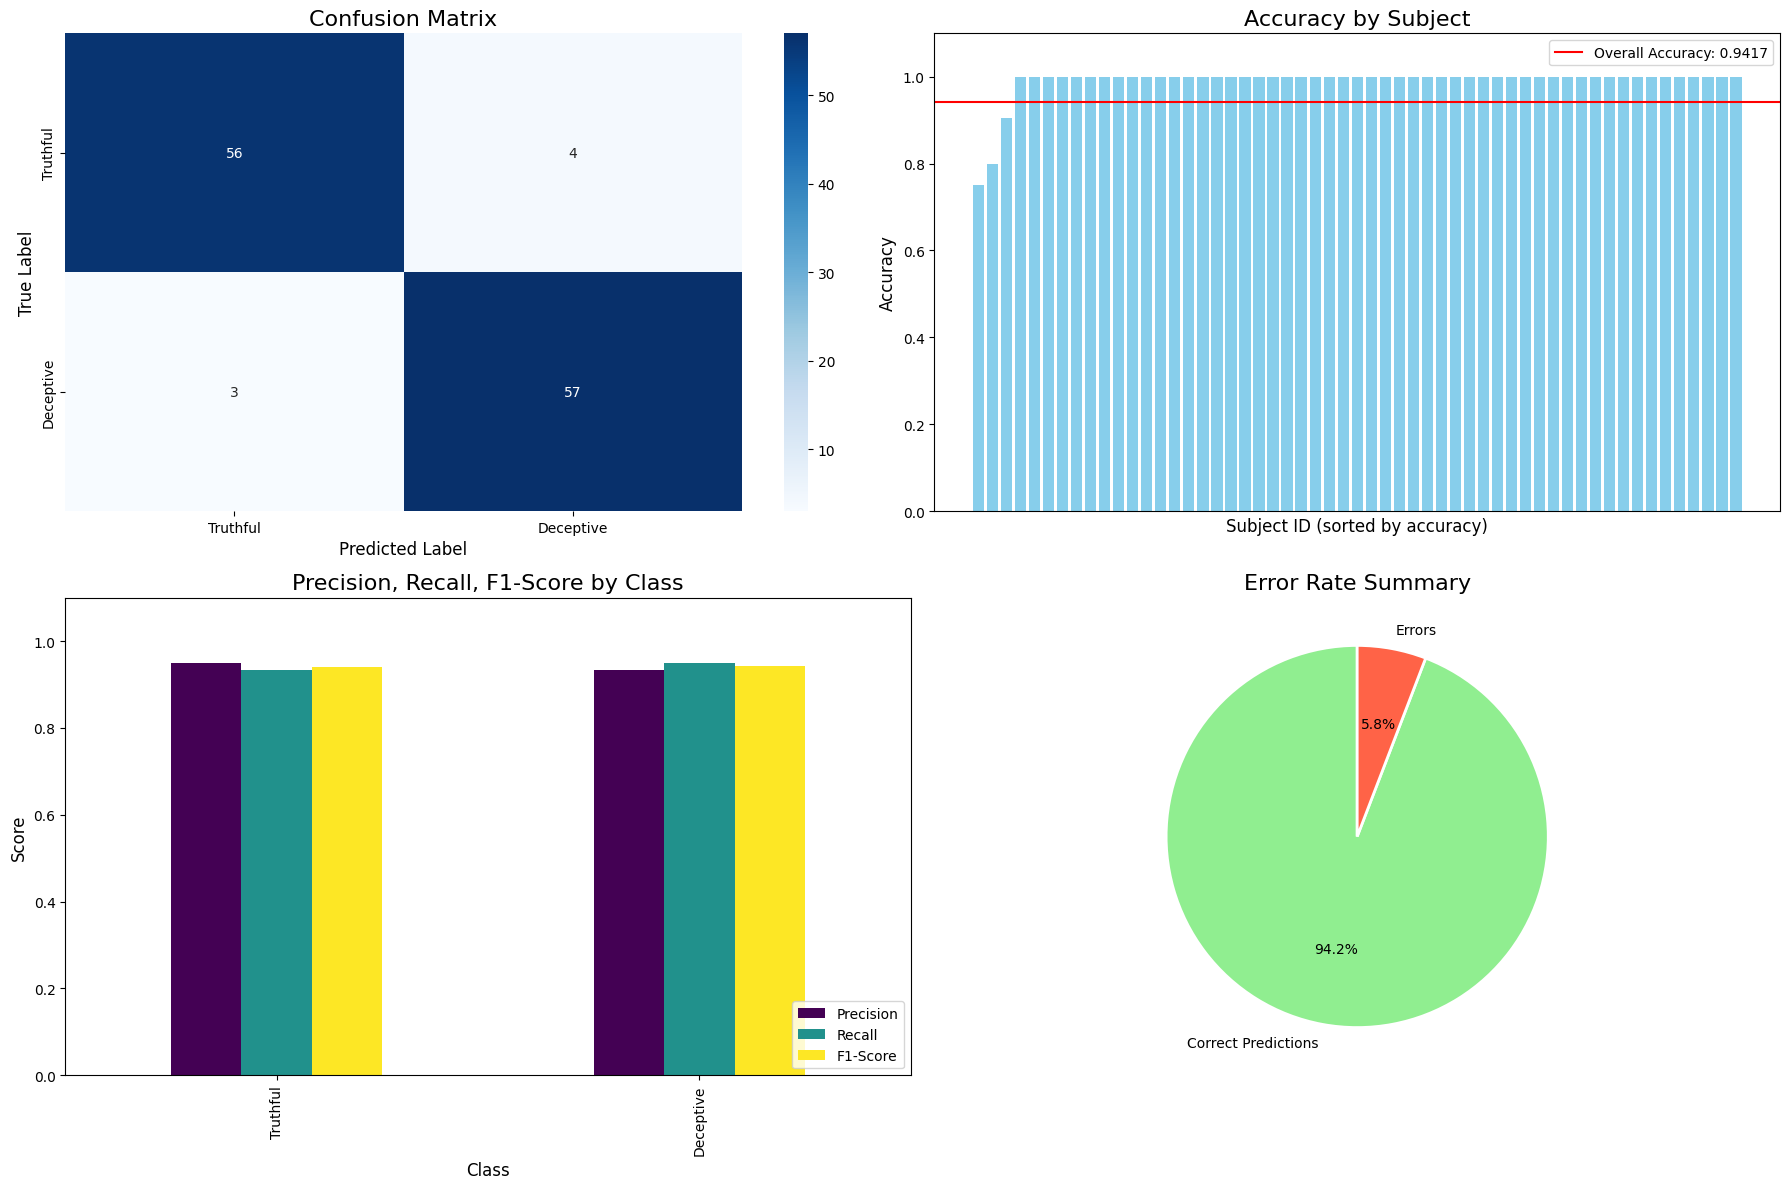


===== DECEPTION DETECTION MODEL EVALUATION =====

Overall Accuracy: 0.9417
Error Rate: 0.0583
Number of Samples Evaluated: 120

Confusion Matrix:
           Truthful  Deceptive
Truthful         56          4
Deceptive         3         57

Classification Report:
              precision    recall  f1-score   support

    Truthful       0.95      0.93      0.94        60
   Deceptive       0.93      0.95      0.94        60

    accuracy                           0.94       120
   macro avg       0.94      0.94      0.94       120
weighted avg       0.94      0.94      0.94       120


Class-specific Metrics:
           Precision    Recall  F1-Score
Truthful    0.949153  0.933333  0.941176
Deceptive   0.934426  0.950000  0.942149

Subject-specific Accuracies:
  subject_1: 0.7500
  subject_2: 0.8000
  subject_4: 0.9048
  subject_10: 1.0000
  subject_11: 1.0000
  subject_12: 1.0000
  subject_13: 1.0000
  subject_14: 1.0000
  subject_15: 1.0000
  subject_16: 1.0000
  subject_17: 1.0000
  s

(0.9416666666666667,
 0.05833333333333335,
 array([[56,  4],
        [ 3, 57]], dtype=int64),
 {'Truthful': {'precision': 0.9491525423728814,
   'recall': 0.9333333333333333,
   'f1-score': 0.9411764705882353,
   'support': 60.0},
  'Deceptive': {'precision': 0.9344262295081968,
   'recall': 0.95,
   'f1-score': 0.9421487603305784,
   'support': 60.0},
  'accuracy': 0.9416666666666667,
  'macro avg': {'precision': 0.9417893859405391,
   'recall': 0.9416666666666667,
   'f1-score': 0.9416626154594068,
   'support': 120.0},
  'weighted avg': {'precision': 0.9417893859405392,
   'recall': 0.9416666666666667,
   'f1-score': 0.9416626154594068,
   'support': 120.0}})

In [3]:
# Import the evaluation module
import importlib.util
spec = importlib.util.spec_from_file_location("deception_evaluation", "deception_evaluation.py")
deception_evaluation = importlib.util.module_from_spec(spec)
spec.loader.exec_module(deception_evaluation)

# Run the evaluation
model_checkpoint_dir = "multimodal_checkpoints_simple"  # Path to your model checkpoints
deception_evaluation.evaluate_model_performance(
    model_checkpoint_dir, 
    mapped_subject_ids,  # Subject IDs from your LOSO cross-validation
    nlp_features,        # NLP features extracted from transcriptions
    audio_features,      # Audio features extracted from videos
    visual_features,     # Visual features extracted from videos
    annotations,         # Ground truth labels (0 or 1)
    DEVICE               # Your device (cpu or cuda)
)